# Hierarchical Bayesian Modelling in Real life

This notebook was created for PyData NYC 2018.  

### Import all necessary libraries

In [1]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import metrics
import seaborn as sns
from theano import shared

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Background

## Campaign spend data

This data comes from 13K digital marketing campaigns that were run since 2016.  Besides business ID, we have a set of variables that will be important to the model.  

billed_amount : The amount billed for the campaign.  This is based on real data, but is not itself real.  Privacy issues and all that.

log_billed_amount : The log of billed_amount.  Typically, spend amounts are log-normally distributed.  There's a small number of high spenders, and a large number of low spenders.

product : The products we'll be focused on. They are as follows:
    - Display = Display advertising, like you might see on a website
    - SEM = Search Engine Marketing, dealing with "sponsored" search results in Google and Bing
    - SEO = Search Engine Optimization, general name for services that aim to increase "organic" traffic, or traffic outside of paid services
    - Social Ads = Advertising on social networks, specifically Facebook and Instagram
    - Email = Direct email advertising, like you might get in your inbox.
    
size : Size of the company.  We have grouped this into four categories: Less than 50 employees, between 50 and 100,  more than 100 and "unavailable".  Unavailable just means we were unable to capture this information.

region : The high-level US region of the company headquarters: Northeast, South, Midwest or West.

In [2]:
# reading in data
campaign_data = pd.read_csv('spend_data_distribute_short.csv')

### Initial descriptives
We run these just so we have a sense of what our data looks like.  For this tutorial, we will be focusing on Product and Region, so we'll pay close attention to that.

In [3]:
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
clr_dict = dict(zip(campaign_data['product'].unique(), clrs))

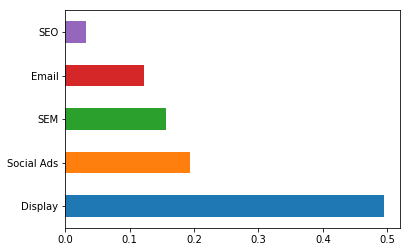

In [4]:
campaign_data['product'].value_counts(normalize=True).plot(
    kind='barh', color=clr_dict.values());

In [5]:
campaign_data.shape

(3928, 11)

## Constructing the models in PyMC3
Now we get into the fun part.  We'll be constructing 3 models here:

1) Pooled model: This is the non-hierarchical approach.  We estimate a single $\alpha$ and a single $\beta$ for each feature.  For the $\alpha$ to have meaning, we'll need to include a reference category with each of our features.  The easiest way to do this is to just one-hot encode the features.  In math:



2) Product-level $\alpha$: This is where we start getting hierarchical.  In this model, we replace our $\alpha$ with $\alpha_p$ for p in {SEO, Email Marketing, SEM, Social, DisplayOnTarget}.  Essentially, a product-level intercept.  These product-level intercepts are drawn from the same distribution with their own set of hyperpriors. 



3) Product and region-level $\alpha$: Now we also add another group-level $\alpha$, $\alpha_r$ for r in {Northeast, South, Midwest, West}.  We have both product-level and region-level intercepts.  Region-level intercept is drawn from its own distribution, which is separate from both the $\beta$'s distribution and $\alpha_p$'s distribution.




In [23]:
# for pooled: need dummy variables
dummy_dict = {}
shared_vars = {}
for c in ['product', 'size', 'region', 'industry']:
    dummy_dict[c] = pd.get_dummies(campaign_data[c]).iloc[:,1:].values
    # setting these as shared variables, will explain later
    shared_vars[c] = shared(dummy_dict[c])
# additional shared vars
shared_vars['product_idx'] = shared(campaign_data.product_idx.values)
shared_vars['region_idx'] = shared(campaign_data.region_idx.values)

In [7]:
def run_model(model, m_name, trace_num=5000, tune=1000, chains=4, display=True):
    # utility function for running model, displaying traceplots and diagnostics
    with model:
        trace = pm.sample(trace_num, tune=tune, chains=chains)[tune:]
    if display:
        pm.plots.traceplot(trace, combined=True)
    return(trace)

In [8]:
model_dict = {}
# non-hierarchical / pooled
with pm.Model() as model:
    product_betas = pm.Normal('product_betas', mu=0., sd=1.0, 
                              shape=campaign_data['product'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=0., sd=1.0, 
                           shape=campaign_data['size'].nunique()-1)
    region_betas = pm.Normal('region_betas', mu=0., sd=1.0,
                             shape=campaign_data['region'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=0., sd=1.0,
                               shape=campaign_data['industry'].nunique()-1)
    intercept = pm.Normal('Intercept', 0., sd=1.0)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = intercept+pm.math.dot(product_betas, shared_vars['product'].T)+\
        pm.math.dot(size_betas, shared_vars['size'].T)+\
        pm.math.dot(region_betas, shared_vars['region'].T)+\
        pm.math.dot(industry_betas, shared_vars['industry'].T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['pooled'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, industry_betas, region_betas, size_betas, product_betas]
Sampling 4 chains: 100%|██████████| 16000/16000 [03:39<00:00, 72.92draws/s] 
The number of effective samples is smaller than 10% for some parameters.


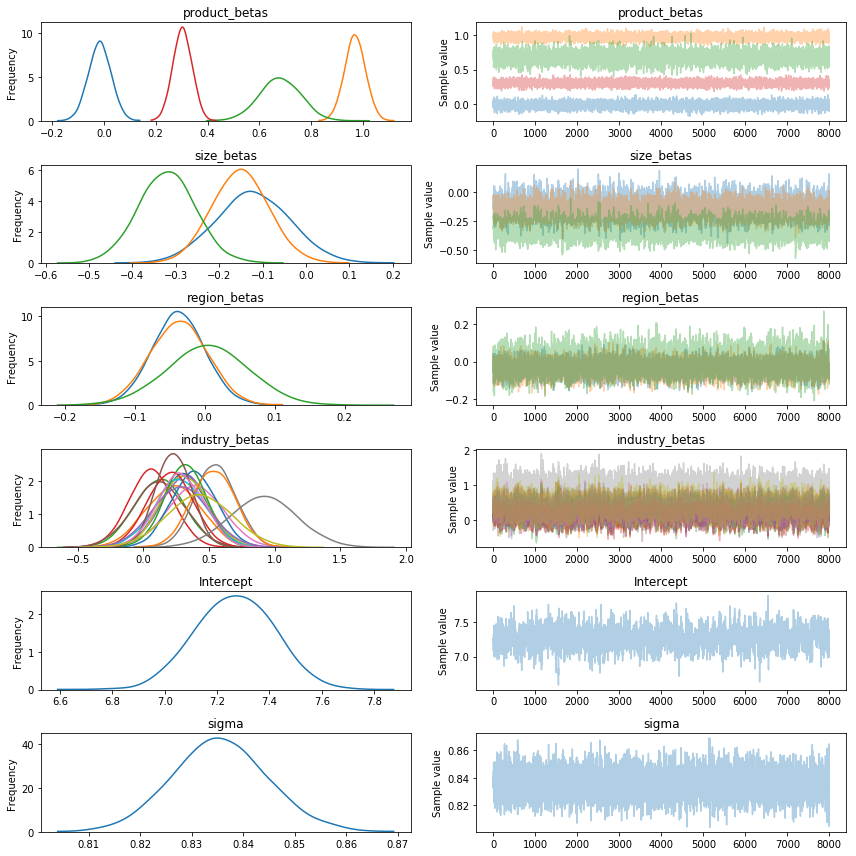

In [9]:
trace_dict = {}
trace_dict['pooled'] = run_model(model_dict['pooled'], 'pooled', trace_num=3000, tune=1000)

### Interpreting PyMC3's traceplots
Let's break here to take a look at exactly what we're seeing in the plots above.

On the right, we're seeing the results of the No U-Turn sampler PyMC3 automatically assigned to our parameters.  As you remember, a sampler draws from the posterior distribution by only "accepting" a value if it increases the likelihood of the data.  You can see the movement of that sampler (i.e. the "trace") in these plots.  Typically, a good trace will fully explore the probability space and not get stuck in certain areas.  For more information on how to escape these narrowed traces, [read more at Thomas Wiecki's blog](https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered).

On the left you see our posterior distribution.  We've enforced normal priors here, so it's to be expected that we're seeing a normal distribution returned.  The doubling of the lines you're seeing are from different sampler runs (i.e. "chains").  It's good practice to check that the two chains don't differ much from one another.

So now let's press ahead with the hiearchical formulations:

In [27]:
# hiearchical - product
with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # product-level intercept
    product_alphas = pm.Normal('product_alphas', mu=mu_a, sd=sigma_a, 
                              shape=campaign_data['product'].nunique())
    
    # betas
    region_betas = pm.Normal('region_betas', mu=mu_b, sd=sigma_b,
                             shape=campaign_data['region'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=mu_b, sd=sigma_b, 
                           shape=campaign_data['size'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=mu_b, sd=sigma_b,
                               shape=campaign_data['industry'].nunique()-1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = product_alphas[shared_vars['product_idx']]+\
        pm.math.dot(size_betas, shared_vars['size'].T)+\
        pm.math.dot(region_betas, shared_vars['region'].T)+\
        pm.math.dot(industry_betas, shared_vars['industry'].T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['product_alphas'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, industry_betas, size_betas, region_betas, product_alphas, sigma_beta, mu_beta, sigma_alpha, mu_alpha]
Sampling 4 chains: 100%|██████████| 16000/16000 [02:40<00:00, 99.89draws/s] 
The number of effective samples is smaller than 25% for some parameters.


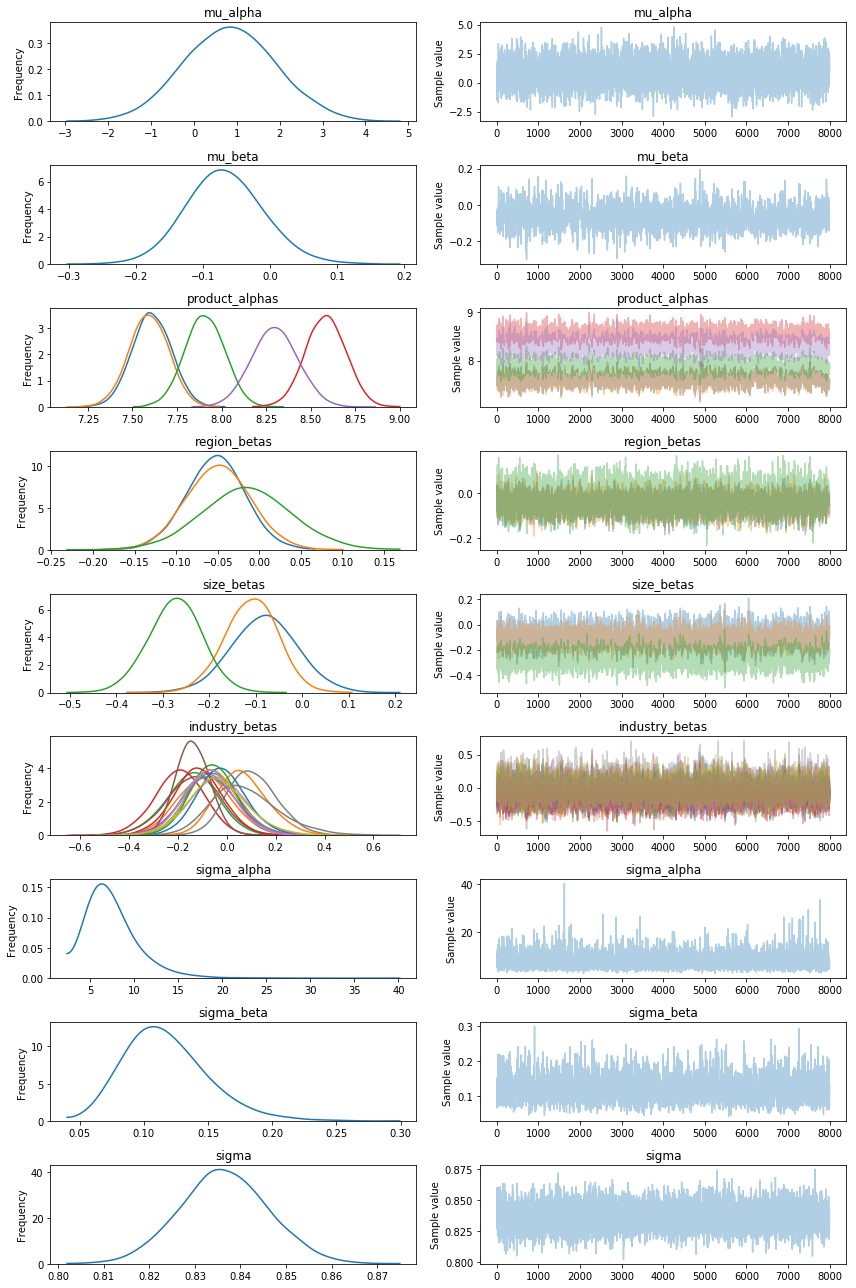

In [47]:
for m in ['product_alphas']:
    trace_dict[m] = run_model(model_dict[m], m, trace_num=3000, tune=1000)

In [121]:
# hiearchical - product and region
with pm.Model() as model:
    # Hyperpriors
    mu_a_product = pm.Normal('mu_a_product', mu=0., sd=1)
    sigma_a_product = pm.HalfCauchy('sigma_a_product', beta=1)
    mu_a_region = pm.Normal('mu_a_region', mu=0., sd=1)
    sigma_a_region = pm.HalfCauchy('sigma_a_region', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)    
    
    # product and region-level intercepts
    product_alphas = pm.Normal('product_alphas', mu=mu_a_product, sd=sigma_a_product, 
                              shape=campaign_data['product'].nunique())
    region_alphas = pm.Normal('region_alphas', mu=0, sd=1,
                         shape=campaign_data['region'].nunique())
    
    # betas
    size_betas = pm.Normal('size_betas', mu=mu_b, sd=sigma_b, 
                           shape=campaign_data['size'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=mu_b, sd=sigma_b,
                               shape=campaign_data['industry'].nunique()-1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = product_alphas[shared_vars['product_idx']]+\
        region_alphas[shared_vars['region_idx']]+\
        pm.math.dot(size_betas, shared_vars['size'].T)+\
        pm.math.dot(industry_betas, shared_vars['industry'].T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['product_region_alphas'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, industry_betas, size_betas, region_alphas, product_alphas, sigma_beta, mu_beta, sigma_a_region, mu_a_region, sigma_a_product, mu_a_product]
Sampling 2 chains: 100%|██████████| 8000/8000 [07:42<00:00, 12.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


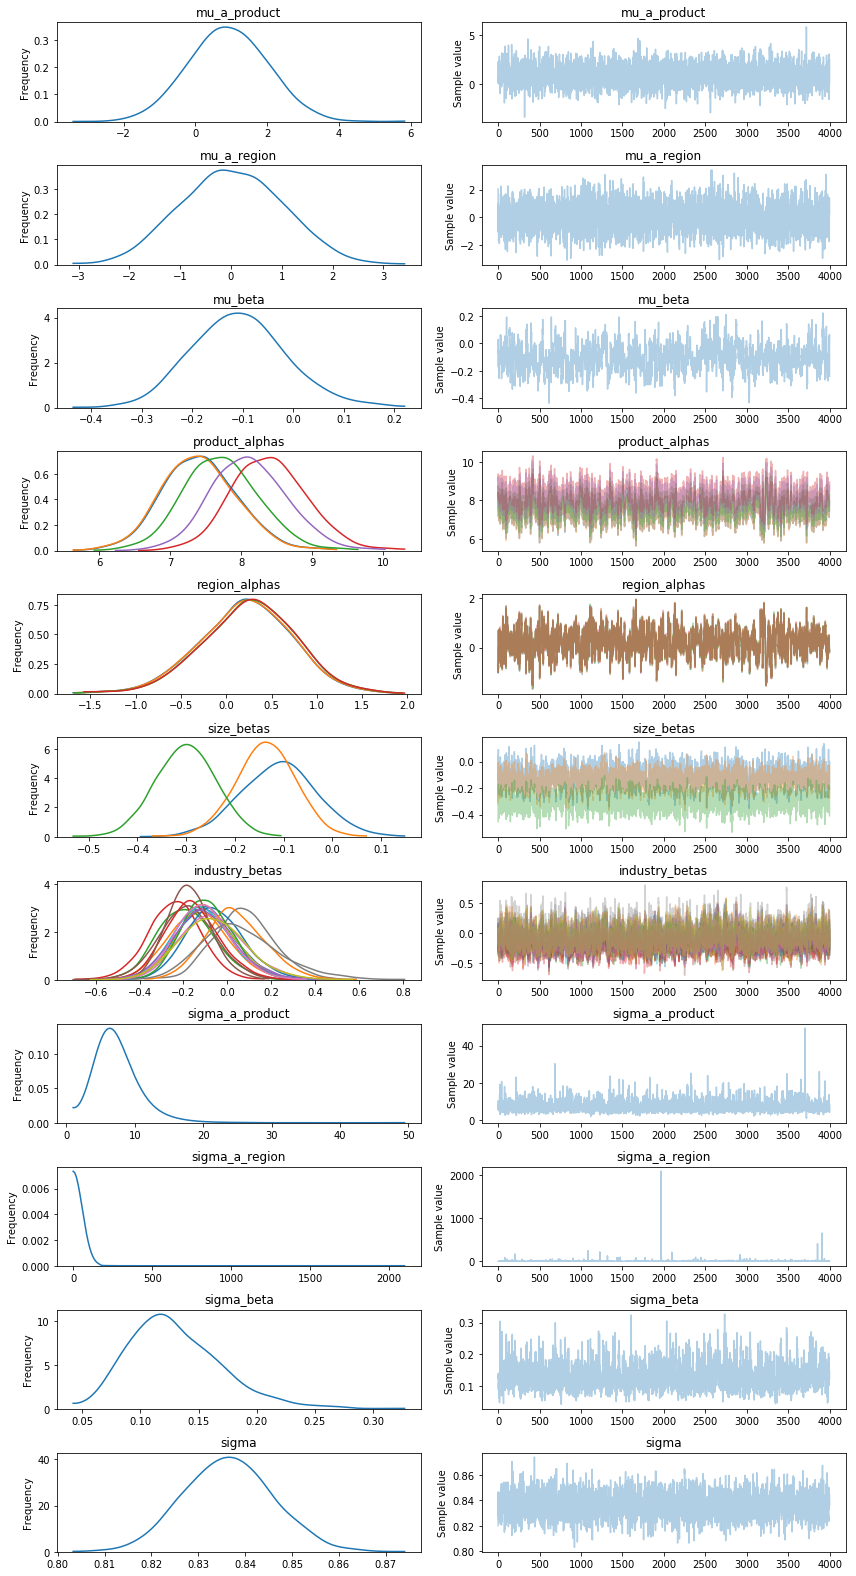

In [122]:
for m in ['product_region_alphas']:
    trace_dict[m] = run_model(model_dict[m], m, trace_num=3000, tune=1000, chains=2)

### Evaluating hierarchical traceplots
Though it varies by run, we will occasionally see a warning about our trace not achieving the "acceptance probability" or about the effective sample size.  These are some common warnings that might pop up, so let's discuss them briefly.


#### Some common warnings
Not achieving acceptance probability: The acceptance probability is the rate at which a sample proposed by the sampler is accepted.  More info on this [here](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/#Explaining-MCMC-sampling-with-code).  The tuning samples adjust the step sizes to achieve the acceptance probability.  This warning may suggest the need for additional tuning samples or adjusted step sizes.

Effective sample size: [Effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size) is the sample size accounting for correlation between observations. MCMC samples are by nature correlated with one another.  If this autocorrelation is particularly high, this reduces the effective sample size.  Both small and large step sizes can contribute to autocorrelation.  Again, this may require additional tuning, specifying a step size or some smart data "thinning".

#### Examining traceplots
From the looks of it, these region-level alphas don't seem to be much different.  Our sense is that they may not be contributing much to the model.  It makes sense, here, to do some model comparison between all three of the models we've run so far and see which we have evidence to move forward with.  For that, we'll be using something called the Widely-Available Information Criterion (see slides).

In [123]:
waic_df = pm.compare({model_dict['pooled']:trace_dict['pooled'], 
            model_dict['product_alphas']:trace_dict['product_alphas'],
           model_dict['product_region_alphas']:trace_dict['product_region_alphas']})
waic_df.index = ['pooled', 'product_alphas', 'product_region_alphas']
waic_df

/Users/benjaminbatorsky/anaconda/envs/devpy3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
pooled,9764.54,20.93,0,0.67,106.32,0,0
product_alphas,9765.46,22.08,0.92,0,106.42,1.31,0
product_region_alphas,9768.94,30.65,4.4,0.33,106.31,7.81,1


Interestingly, the pooled model actually has lower WAIC than either of the hierarchical implementations.  It may be that we need to tweak some of our priors or other parameters in the model in order to really get the value from a hierarchical implementation.  But these numbers are not hugely different from one another and it might make more sense to look at what sort of predictions we're getting out of them before we jump to conclusions.

### Posterior Predictive Checks
Posterior predictive checks are based on the posterior predictive distribution, which are explained in the slides.  PyMC3 allows us to sample from this distribution for "checks" on the predictions.  A nice way to do that is to look at a set of these samples compared to the source distribution.

In [48]:
selected_model = 'product_alphas'
ppc_dict = {}
ppcs = pm.sample_ppc(trace_dict[selected_model], model=model_dict[selected_model], samples=1000)['y']

100%|██████████| 1000/1000 [00:02<00:00, 454.30it/s]


In [49]:
print(ppcs.shape)
ppcs

(1000, 3928)


array([[8.01758424, 9.19324264, 6.78623372, ..., 6.69536437, 8.73492084,
        8.35383328],
       [7.11583659, 7.9719892 , 6.98411965, ..., 6.28233956, 7.72153161,
        7.09466137],
       [5.45221809, 8.01994087, 6.48764831, ..., 7.94760976, 6.70778072,
        8.2487519 ],
       ...,
       [7.52739689, 6.41024674, 7.29809522, ..., 6.40595522, 5.94746658,
        7.76423118],
       [7.08375072, 8.15715583, 6.24511329, ..., 7.16192854, 7.08314312,
        5.95858816],
       [6.41482569, 7.81210539, 9.36353679, ..., 5.91160124, 6.23675603,
        7.37081502]])

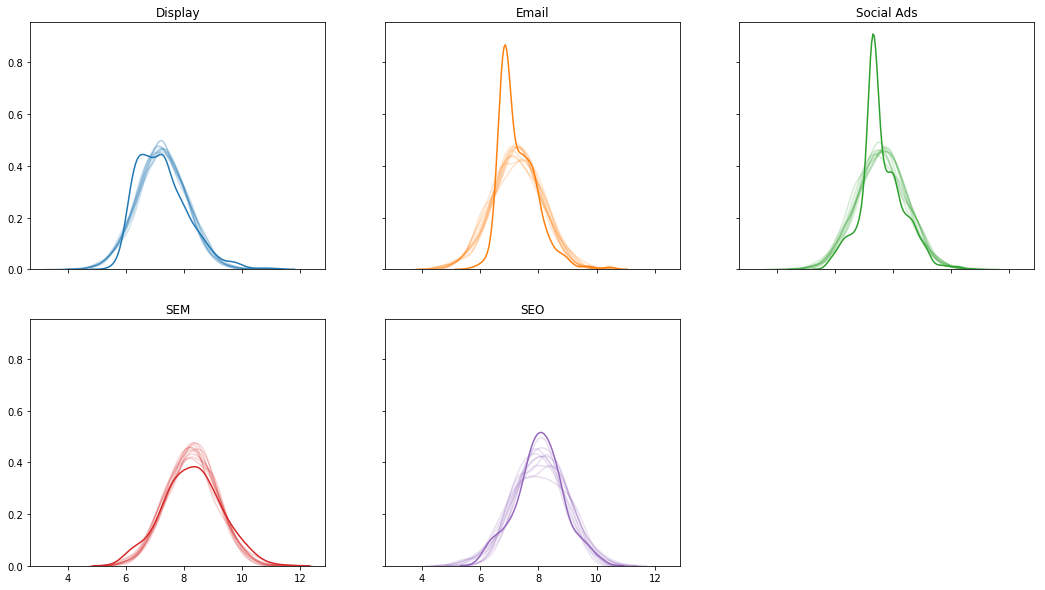

In [50]:
# dictionary for storing product-specific data
product_ppcs = {}
fig, axs = plt.subplots(2, 3, figsize=(18,10), sharey=True, sharex=True)
for i, product in enumerate(campaign_data['product'].unique()):
    if i<3:
        r = 0
        c = i
    else:
        r = 1
        c = i-3
    # subset ppcs to just product
    # ppcs are formatted (n_samples, n_observations)
    product_ppc = ppcs[:, (campaign_data['product']==product).values]
    product_ppcs[product] = product_ppc
    # get a random selection of samples to plot
    rand_samples = np.random.randint(len(ppcs), size=10)
    # plot samples
    for sample in product_ppc[rand_samples]:
        sns.kdeplot(sample, ax=axs[r,c], color=clr_dict[product], alpha=.2)
    # plot actual
    sns.kdeplot(campaign_data[campaign_data['product']==product]['log_billed_amount'], 
                ax=axs[r,c], color=clr_dict[product], legend=None)
    axs[r,c].set_title(product)
fig.delaxes(axs[r, c+1])

#### T-test for significance of differences
There are a number of ways to test how different these sample distributions are from the source distributions.  But a quick method would just be to test the difference in means.  So let's do that.

In [204]:
from scipy.stats import ttest_ind
from copy import deepcopy

In [71]:
# run for each product, take the average t and p values
for product in product_ppcs:
    print('\n%s' % product)
    t, p = ttest_ind(product_ppcs[product], campaign_data[campaign_data['product']==product]['log_billed_amount'])
    print('Average difference: %s' % mean_diff)
    print('Average t-value: %s' % np.mean(t))
    print('Average p-value: %s' % np.mean(p))


Display
Average difference: 0.0008310962749575973
Average t-value: 0.03575307104162282
Average p-value: 0.07112834606038702

Email
Average difference: 0.0008310962749575973
Average t-value: 0.011331690159128112
Average p-value: 0.2282998595892457

Social Ads
Average difference: 0.0008310962749575973
Average t-value: -0.046327459936274754
Average p-value: 0.22782812941185882

SEM
Average difference: 0.0008310962749575973
Average t-value: 0.030236827549276042
Average p-value: 0.2649559247081473

SEO
Average difference: 0.0008310962749575973
Average t-value: -0.012536805987712974
Average p-value: 0.4447445053135873


### Productionizing
Now we come back to why we used shared variables from Theano to set up our models.  Shared variables allow us to change out the data being used in the model.  That allows for functionality like changing data based on a user's query.  Let's mock up a query we might get from an API that contains some customer attributes.

In [272]:
# copy original shared data
original_shared = deepcopy(shared_vars)

In [315]:
def run_query(query_json):
    # subsetting data to customers specified in query
    subset_data = campaign_data.query('&'.join(["({}=='{}')".format(k,v) for k,v in customer_query.items()]))
    for c in shared_vars.keys():
        shared_vars[c].set_value(original_shared[c].get_value()[subset_data.index])
    # run ppcs
    query_ppcs = pm.sample_ppc(trace_dict[selected_model], model=model_dict[selected_model], samples=100)['y']
    # create data for histogram
    ppc_series = pd.Series(np.median(query_ppcs, axis=1)).copy(deep=True)
    # converting to dollars (simple transformation)
    ppc_series = np.exp(ppc_series)
    return(ppc_series)

In [316]:
# mocking a customer query
customer_query = {'product':'Display', 'region':'northeast', 'industry': 'fullservice_restaurants'}
display_ppc = run_query(customer_query)

100%|██████████| 100/100 [00:00<00:00, 696.44it/s]


In [317]:
# now what if that customer was interested in SEM?
customer_query.update({'product':'SEM'})
sem_ppc = run_query(customer_query)

100%|██████████| 100/100 [00:00<00:00, 722.72it/s]


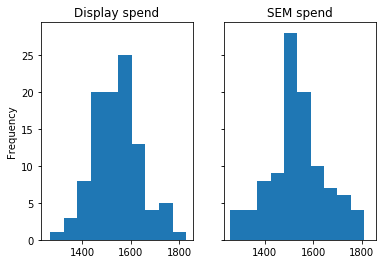

In [324]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
display_ppc.plot(kind='hist', ax=axs[0], title='Display spend')
sem_ppc.plot(kind='hist', ax=axs[1], title='SEM spend')